# Setup

In [1]:
# !pip install shap
# !pip install eli5
# !pip install lime

In [2]:
import warnings
warnings.filterwarnings("ignore")

Required library imports, matplotlib setup

In [3]:
# Checking runtime environment is Python ≥ 3.5 and `Scikit-Learn` ≥ 0.20
import sys
import sklearn
assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"

# Setup Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Other imports
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import plotly.express as px
import shap
import random
from lime import lime_tabular

# Constants
rr = 42

**Evaluation Setup**

Display the confusion matrix, accuracy, sensitivity, specificity, F-beta measure, ROC curve and Precision-accuracy curve of given classifiers

In [4]:
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate(models, X_test, y_true, title=''):
    y_preds = [i.predict(X_test) for i in models]
    res = pd.DataFrame(
        index=[i.__class__.__name__ for i in models],
        columns=['accuracy', 'sensitivity', 'specificity', 'F0.5', 'F1', 'F2'])
    
    # Plot the confusion matrix
    plt.figure(figsize=(15, 4))
    for x, model in enumerate(models):
        name = model.__class__.__name__
        y_pred = y_preds[x]
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1,len(models), x+1)
        plt.imshow(cm, cmap='GnBu')
        plt.colorbar()
        for i, j in [[0,0], [0,1], [1,0], [1,1]]:
            plt.text(i, j, cm[i,j], 
                    color='white', ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.25))
        plt.xticks(np.arange(0, 2, step=1)) 
        plt.yticks(np.arange(1, -1, step=-1))   
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(name)
        plt.grid(False)
        
        tn, fp, fn, tp = cm.ravel()
        res['accuracy'][name] = (tp + tn)/(tn + fp + fn + tp)
        res['sensitivity'][name] = tp / (tp + fn)
        res['specificity'][name] = tn / (fp + tn)
        res['F0.5'][name] = sklearn.metrics.fbeta_score(y_true, y_pred, beta=0.5) 
        res['F1'][name] = sklearn.metrics.fbeta_score(y_true, y_pred, beta=1) 
        res['F2'][name] = sklearn.metrics.fbeta_score(y_true, y_pred, beta=2) 
    
    display(res)
    plt.show()
    
    y_scores = [i.predict_proba(X_test)[:,1] for i in models]
    # Plot ROC and Precision Recall Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    legend = []
    for x, model in enumerate(models):
        y_pred, y_score = y_preds[x], y_scores[x]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} (AUC = %0.2f)'%roc_auc)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_prec = average_precision_score(y_true, y_score)
        legend.append(f'{model.__class__.__name__} (AP = %0.2f)' % avg_prec)
        ax2.step(recall, precision, where='post')
    
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(b=True)
    ax2.set(xlabel='Recall', ylabel='Precision', title='Precision Recall Curve')
    ax2.legend(legend)
    ax2.grid(b=True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.5)
    plt.show()

# Loading and Inspecting the dataset

In [5]:
import requests
import tarfile
url = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz"
target = "latestdata.tar.gz"

In [6]:
# Download the latest dataset from GitHub and save it locally
response = requests.get(url, stream=True)
if response.status_code == 200:
    print("Downloading the dataset...")
    with open(target, "wb") as dataset:
        dataset.write(response.raw.read())
        print("Finished downloading the dataset.")
else:
    print("Could not fetch dataset")

Finished downloading the dataset.


In [7]:
# Load the dataset into a DataFrame
dataset_tar = tarfile.open(target, 'r')
try:
    f = dataset_tar.extractfile('latestdata.csv')
    # The dataset has mixed datatypes in several columns therefore low_memory flag has to be set to False
    covid_data = pd.read_csv(f, index_col='ID', low_memory=False)
except Exception as e:
    print("Error:", e)
else:
    print("Successfully read the dataset")

Successfully read the dataset


In [8]:
covid_data

age     sex  ... data_moderator_initials travel_history_binary
ID                        ...                                              
000-1-1      NaN    male  ...                     NaN                   NaN
000-1-10      78    male  ...                     NaN                   NaN
000-1-100     61  female  ...                     NaN                   NaN
000-1-1000   NaN     NaN  ...                     NaN                   NaN
000-1-10000  NaN     NaN  ...                     NaN                   NaN
...          ...     ...  ...                     ...                   ...
010-99995     52  female  ...                     NaN                 False
010-99996     52  female  ...                     NaN                 False
010-99997     52  female  ...                     NaN                 False
010-99998     52    male  ...                     NaN                 False
010-99999     52    male  ...                     NaN                 False

[2676311 rows x 32 columns]

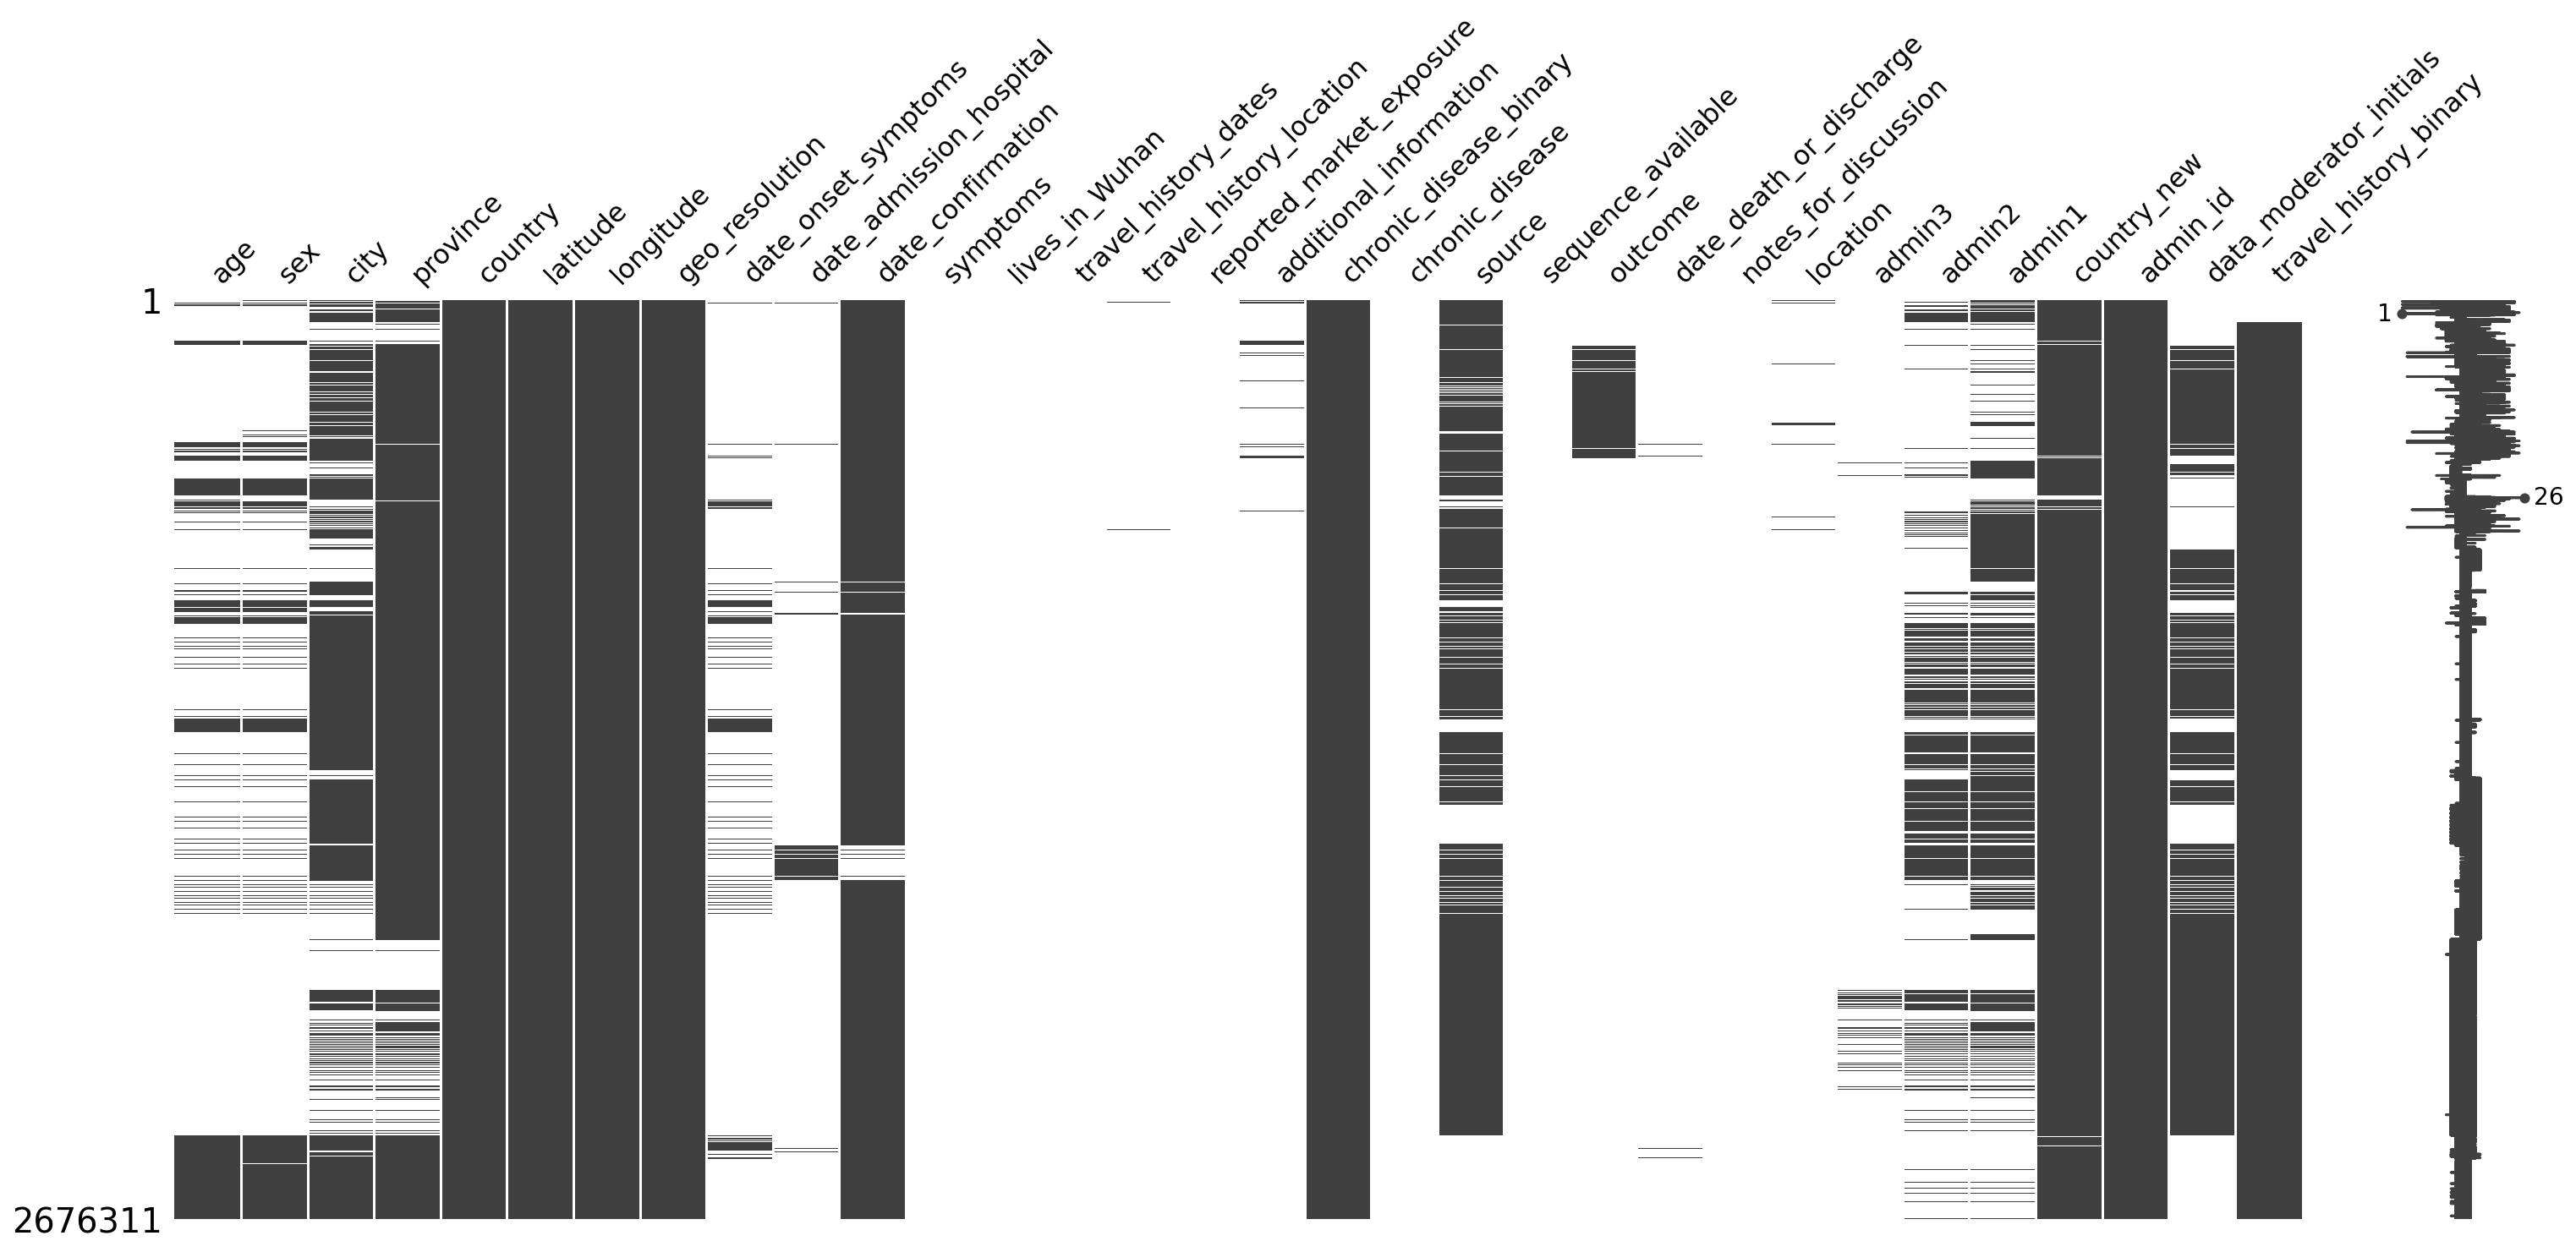

In [9]:
# Visualise the missing values in the dataset side by side
msno.matrix(covid_data)

In [10]:
# Visualise the geographic distribution of the recorded cases in the datset
num_cases = covid_data.groupby('country').size().reset_index(name='No. Cases')
fig = px.choropleth(num_cases, locations="country", locationmode='country names',
                    color="No. Cases", hover_name="country", color_continuous_scale='reds',
                    title='Total number of COVID-19 cases in the dataset by country')

fig.show()

# Cleaning

In [11]:
# Delete columns with no information, repeated information or information not related to Covid-19 cases 
covid_data.drop(columns=['symptoms', 'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
                         'reported_market_exposure', 'additional_information','chronic_disease', 'source', 
                         'sequence_available','notes_for_discussion', 'location', 'admin3', 'admin2', 
                         'admin1','country_new', 'admin_id', 'data_moderator_initials','travel_history_binary', 
                         'geo_resolution'], inplace=True)

# Dropping index as case ids are not required
covid_data.reset_index(inplace=True, drop=True)

In [12]:
# Encode the sex attribute
covid_data.sex = covid_data.sex.map({'male':1, 'female':0})
# Convert chronic_disease_binary to int (required for SHAP analysis)
covid_data.chronic_disease_binary = covid_data.chronic_disease_binary.astype(int) 

## Cleaning `age`

> Note - range entries e.g `'25-30'`, with a difference greater the 24 are discarded

In [13]:
covid_data['age'].unique()

array([nan, '78', '61', '66', '27', '17', '51', '68', '26', '30', '53',
       '35', '28', '58', '33', '50', '45', '24', '88', '29', '21', '52',
       '60', '56', '79', '40-49', '82', '25', '40', '20-29', '40-89',
       '60-69', '80-89', '50-59', '13-19', '30-39', '43', '7', '44', '69',
       '16', '47', '8', '10', '55', '38', '42', '34', '62', '39', '71',
       '64', '36', '31', '1', '48', '54', '70-79', '60-60', '65', '46',
       '57', '32', '37', '80-80', '73', '67', '0-6', '0-10', '22', '41',
       '10-19', '70', '96', '20', '63', '19', '1.75', '75', '18-65',
       '0.6666666667', '12', '49', '80', '77', '18', '72', '4', '15',
       '95', '0-18', '23', '65-99', '81', '90-99', '50-69', '85', '91',
       '87', '14', '19-65', '70-70', '60-70', '76', '94', '38-68', '0.5',
       '0.25', '9', '16-17', '5-59', '40-50', '13', '60-', '59', '12-19',
       '74', '18-50', '18-49', '41-60', '61-80', '18-60', '60-99',
       '40-69', '30-69', '40-45', '0-9', '11', '54-56', '0-19', '5'

In [14]:
def parse_age(x):
    if x != x:
        return x
    try:
        return round(float(x), 2)
    except:
        if x[-1] == '-' or x[-1] == '+':
            return int(x[:-1])
        if '-' in x:
            a, b = x.split('-')
            try:
                a, b = int(a), int(b)
                return np.nan if b - a > 24 else round((b-a)/2, 2)  
            except:
                return int(a)
        if 'month' in x:
            return round(int(x.split(' ')[0])/12, 2)
        if 'weeks' in x:
            return 0

covid_data['age'] = covid_data.age.map(parse_age)

## Identifying serious cases

A serious Covid-19 case is defined as the one that requires the patient to be hospitalization or if it leads to death. We can check if the patient was admitted to the hospital by checking for a non-null entry in `date_admission_hospital` column.

In [15]:
covid_data['hosp'] = covid_data.date_admission_hospital.map(lambda x : 1 if x == x else 0)

Similarly a non-null entry in `date_death_or_discharge` column indicates if the patient was hospitalized and/or deceased

In [16]:
hosp_or_dead = covid_data['date_death_or_discharge'].map(lambda x: 'hosp_or_dead' if x==x else np.nan)
covid_data.outcome.fillna(hosp_or_dead, inplace=True)

Finally, we can categorise the outcome and, combine all of the above information into a single column

In [17]:
covid_data.outcome = covid_data.outcome.str.lower()
covid_data.outcome.unique()

array(['critical condition, intubated as of 14.02.2020', 'death',
       'discharge', nan, 'discharged', 'discharged from hospital',
       'not hospitalized', 'recovered', 'recovering at home 03.03.2020',
       'released from quarantine', 'severe', 'stable', 'hosp_or_dead',
       'died', 'dead',
       'symptoms only improved with cough. currently hospitalized for follow-up.',
       'treated in an intensive care unit (14.02.2020)', 'alive',
       'deceased', 'stable condition', 'under treatment',
       'critical condition', 'receiving treatment', 'severe illness',
       'unstable', 'hospitalized', 'migrated', 'migrated_other',
       'https://www.mspbs.gov.py/covid-19.php'], dtype=object)

In [18]:
is_serious = ['hosp_or_dead', 'death', 'died', 'dead', 'severe', 'critical', 'intensive',
              'hospitalized', 'treatment', 'treated', 'discharge', 'discharged']

def classify_outcome(x):
    if x == x and x != 'not hospitalized':
        return int(any([i in is_serious for i in x.split(' ')]))     
    elif x == x:
        return 0
    else:
        return x
    
covid_data['is_serious'] = covid_data.outcome.map(classify_outcome)
covid_data.is_serious.fillna(covid_data.hosp, inplace = True)

## Inspecting Cleaned Dataset

In [19]:
# country is only included for visualisation purposes it will not be used in training
cleaned = covid_data[['age', 'sex', 'latitude', 'longitude', 'country', 'chronic_disease_binary', 'is_serious']]

In [20]:
cleaned = cleaned.dropna()
cleaned.reset_index(drop=True, inplace=True)
cleaned

age  sex   latitude  ...    country chronic_disease_binary  is_serious
0       78.0  1.0  45.297748  ...      Italy                      0         1.0
1       61.0  0.0   1.353460  ...  Singapore                      0         1.0
2       66.0  1.0  45.948140  ...      China                      0         0.0
3       27.0  0.0  42.858020  ...      China                      0         0.0
4       17.0  1.0  43.783530  ...      China                      0         0.0
...      ...  ...        ...  ...        ...                    ...         ...
573692  52.0  0.0  -8.378190  ...       Peru                      0         0.0
573693  52.0  0.0 -12.076530  ...       Peru                      0         0.0
573694  52.0  0.0 -11.932980  ...       Peru                      0         0.0
573695  52.0  1.0 -12.000740  ...       Peru                      0         0.0
573696  52.0  1.0 -11.976260  ...       Peru                      0         0.0

[573697 rows x 7 columns]

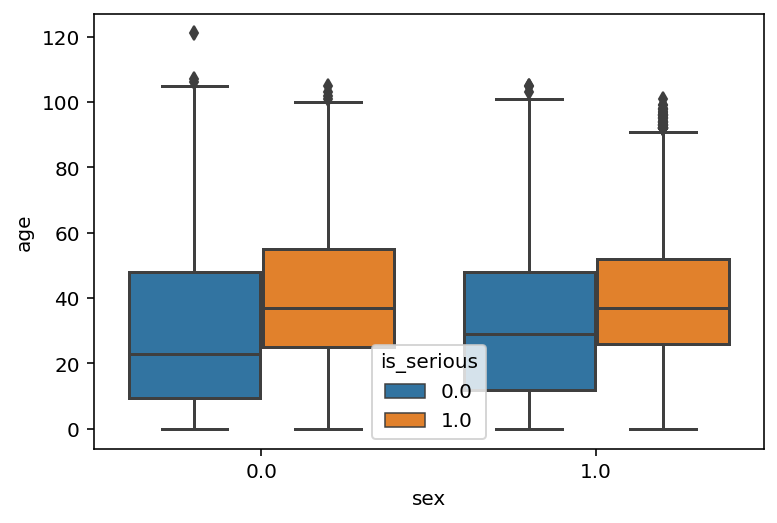

In [21]:
sns.boxplot(data=cleaned, y="age", x='sex', hue='is_serious')

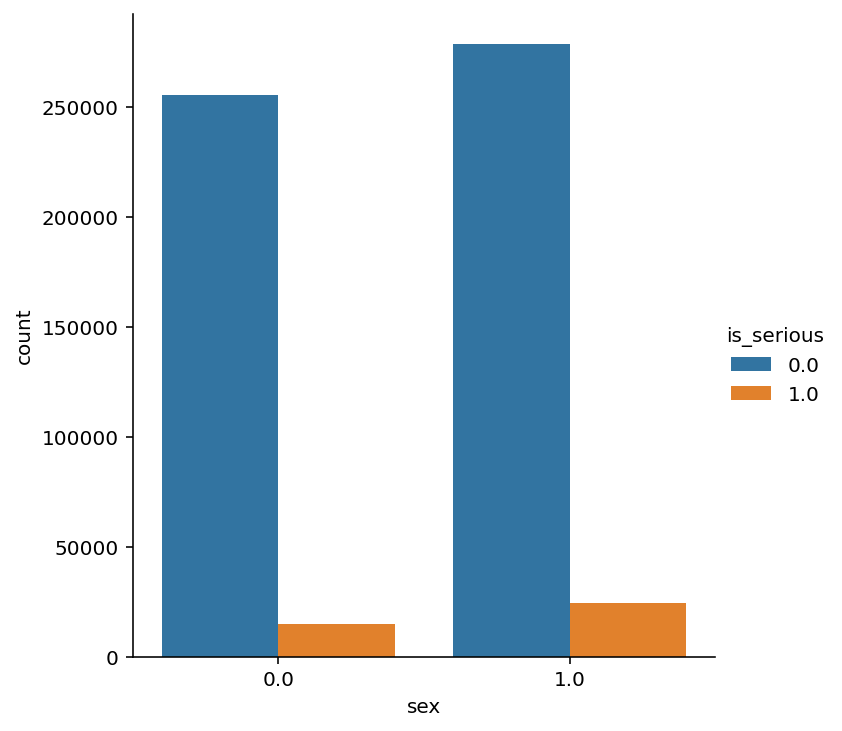

In [22]:
sns.catplot(data=cleaned, x='sex', kind='count', hue='is_serious')

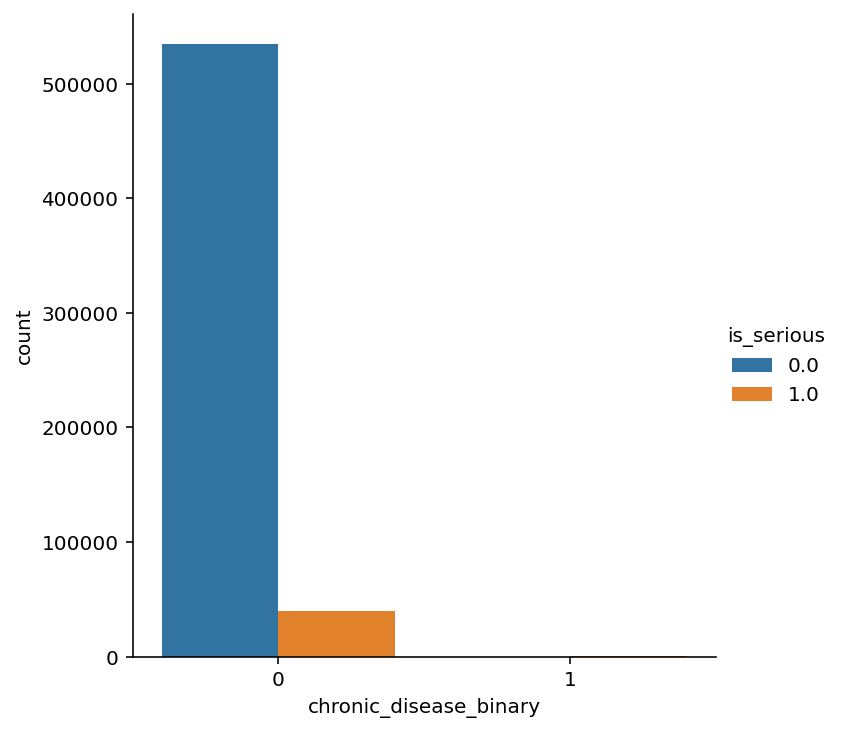

In [23]:
sns.catplot(data=cleaned, x='chronic_disease_binary', kind='count', hue='is_serious')

In [24]:
num_cases = cleaned.groupby('country').size().reset_index(name='No. Cases')
fig = px.choropleth(num_cases, locations="country", locationmode='country names',
                    color="No. Cases", hover_name="country", color_continuous_scale='reds',
                    title='Total number of COVID-19 cases in the cleaned dataset by country')

fig.show()

# Train, test and evaluate models


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## With imbalanced dataset

In [26]:
cleaned['age'] = (cleaned.age - cleaned.age.mean())/cleaned.age.std()
X, y = cleaned.drop(['is_serious', 'country'], axis=1), cleaned.is_serious

# Get ratio of +ve to -Ve cases
a, b = sorted(y.value_counts().to_list())
print(y.value_counts())
print(f'ratio: {round(b//a)}:{1}')

0.0    534170
1.0     39527
Name: is_serious, dtype: int64
ratio: 13:1


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=rr, shuffle=True)

models = [
    RandomForestClassifier(random_state=rr, max_features='sqrt', n_estimators=200),
    KNeighborsClassifier(n_neighbors=15),
    LogisticRegression(random_state=rr)
]

for model in models:
    print("Training", model.__class__.__name__)
    model.fit(X_train, y_train)

Training RandomForestClassifier
Training KNeighborsClassifier
Training LogisticRegression


accuracy sensitivity  ...        F1         F2
RandomForestClassifier  0.981111    0.809158  ...  0.855131   0.826941
KNeighborsClassifier     0.98207    0.804098  ...  0.860715   0.825827
LogisticRegression      0.893719   0.0345758  ...  0.042905  0.0374867

[3 rows x 6 columns]

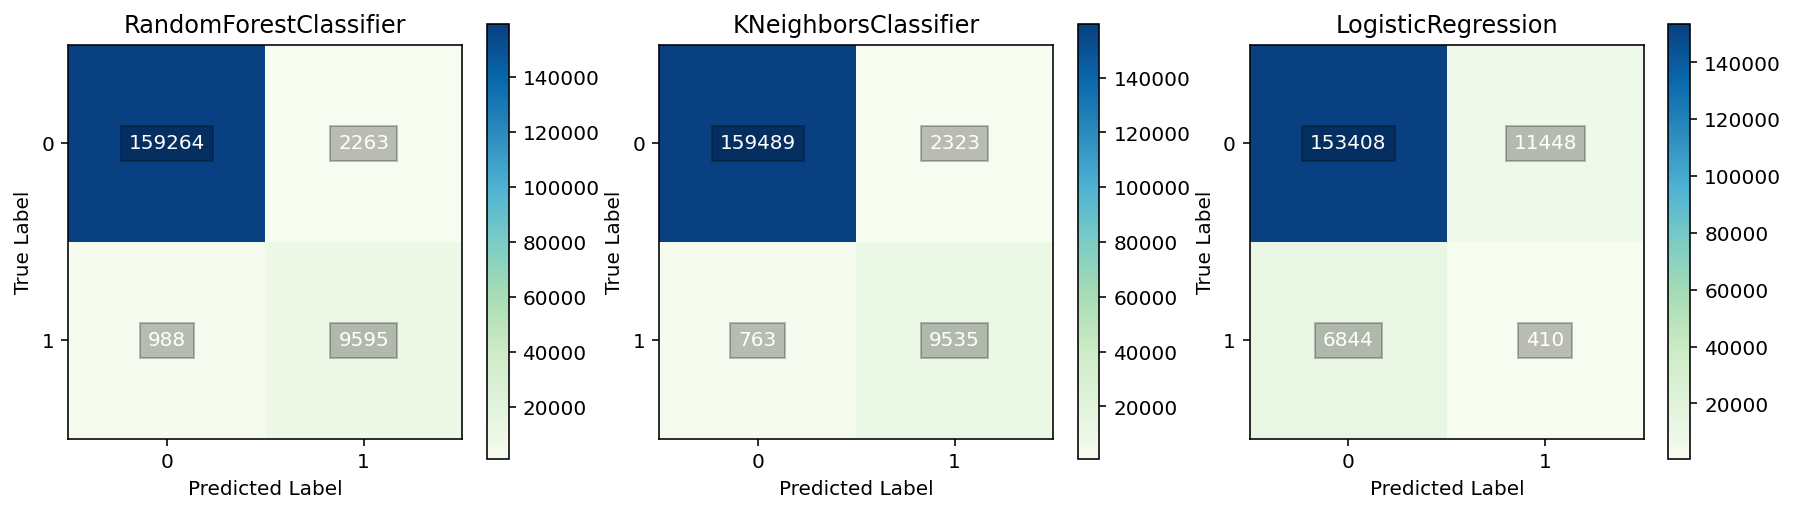

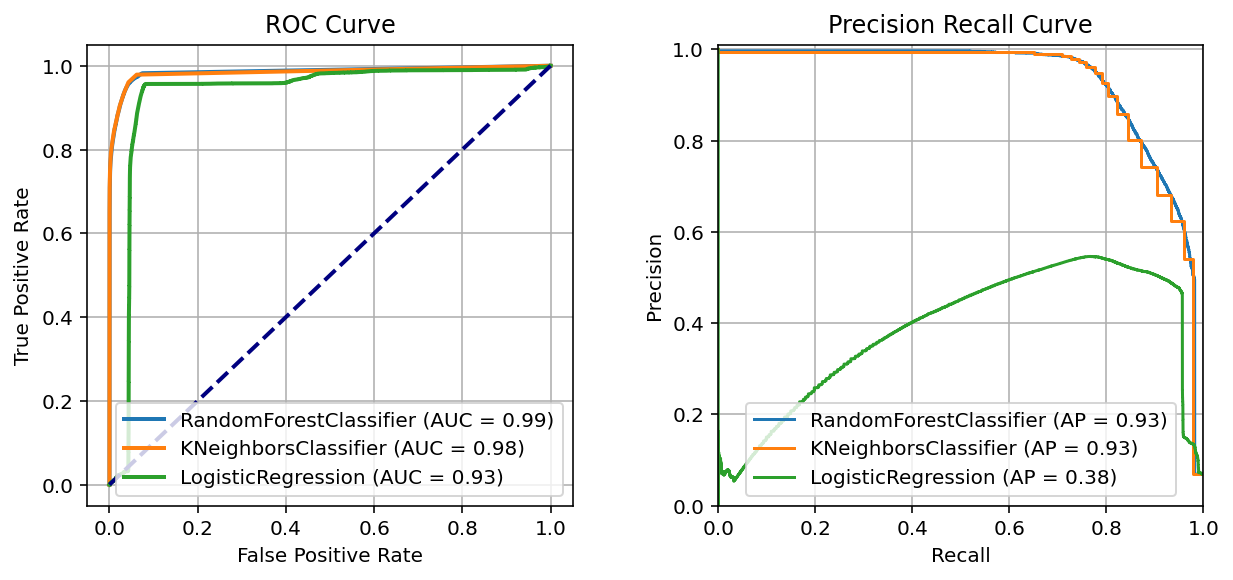

In [28]:
evaluate(models, X_test, y_test)

## With balanced dataset

In [29]:
# Randomly undersample the majority target class
sample_size = min(cleaned['is_serious'].value_counts())
under_sample = lambda x: x.sample(n=sample_size, random_state=rr)
under_sampled = cleaned.groupby(['is_serious']).apply(under_sample).reset_index(drop=True)

X_rus, y_rus = under_sampled.drop(['is_serious', 'country'], axis=1), under_sampled.is_serious

a, b = sorted(y_rus.value_counts().to_list())
print(y_rus.value_counts())
print(f'ratio: {round(b//a)}:{1}')

1.0    39527
0.0    39527
Name: is_serious, dtype: int64
ratio: 1:1


In [30]:
# Inspecting the geographic distribution of the cases of the balanced dataset
num_cases = under_sampled.groupby('country').size().reset_index(name='No. Cases')
fig = px.choropleth(num_cases, locations="country", locationmode='country names',
                    color="No. Cases", hover_name="country", color_continuous_scale='reds',
                    title='Total number of COVID-19 cases in the balanced dataset by country')

fig.show()

In [31]:
base_models = [
    ('Random Forest', RandomForestClassifier(random_state=rr)),
    ('KNeighbors', KNeighborsClassifier()),
    ('LogisticRegression', LogisticRegression(random_state=rr))
]

params = {
    'Random Forest':{
       'max_features': ['sqrt', 'log2'],
       'n_estimators': [50, 100, 300]
    },
    'KNeighbors':{
        'n_neighbors': [7, 11, 19],  
    },
    'LogisticRegression':{
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'max_iter':[1000]
    }
}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, 
                                                    stratify=y_rus, random_state=rr, shuffle=True)
trained_clfs = []
skf = StratifiedKFold(n_splits=3)

for clf_name, clf in base_models:
    grid_search = GridSearchCV(estimator=clf, param_grid=params[clf_name], cv=skf, n_jobs= -1, verbose=True)
    grid_search.fit(X_train, y_train)
    print(clf_name, grid_search.best_score_, grid_search.best_params_)
    trained_clfs.append(grid_search.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


Random Forest 0.9593942589399661 {'max_features': 'sqrt', 'n_estimators': 300}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    7.9s finished


KNeighbors 0.9633698929061505 {'n_neighbors': 11}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.5s finished


LogisticRegression 0.9396605915487739 {'max_iter': 1000, 'solver': 'newton-cg'}


accuracy sensitivity  ...        F1        F2
RandomForestClassifier  0.960029    0.972761  ...   0.96053  0.967831
KNeighborsClassifier     0.96336    0.977737  ...  0.963877  0.972145
LogisticRegression      0.938525    0.958593  ...  0.939732  0.950959

[3 rows x 6 columns]

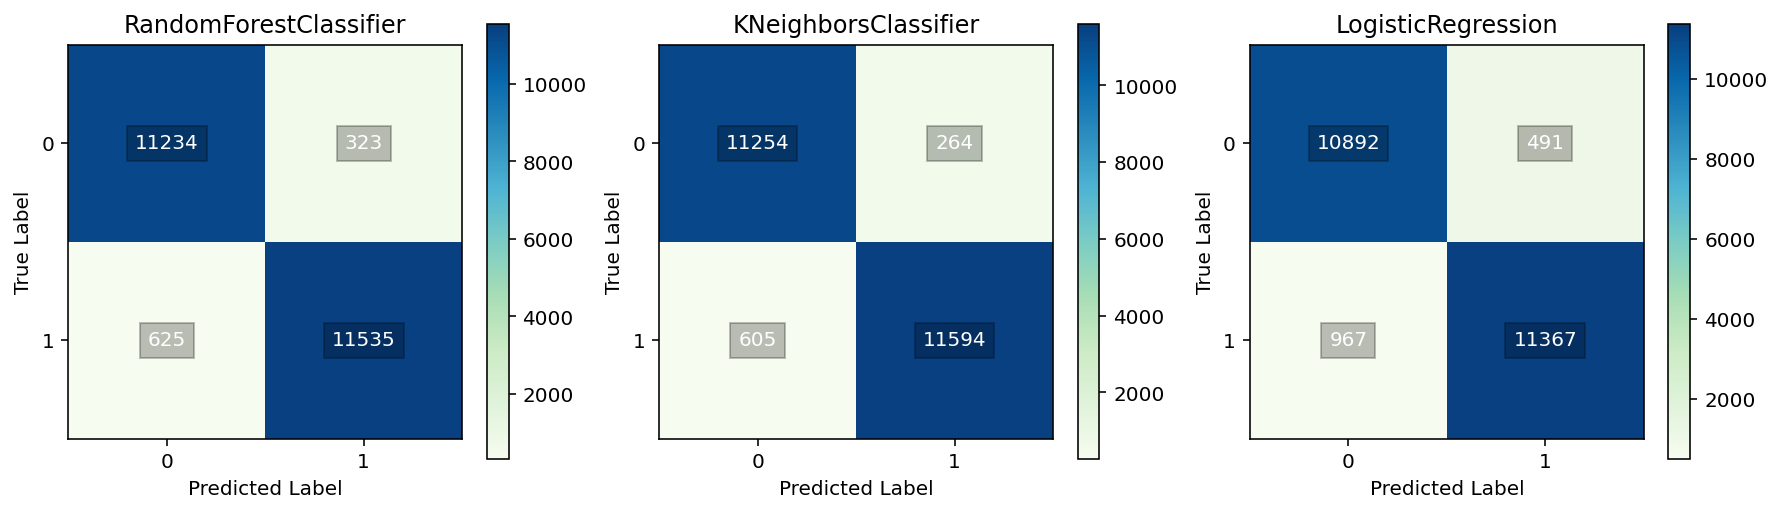

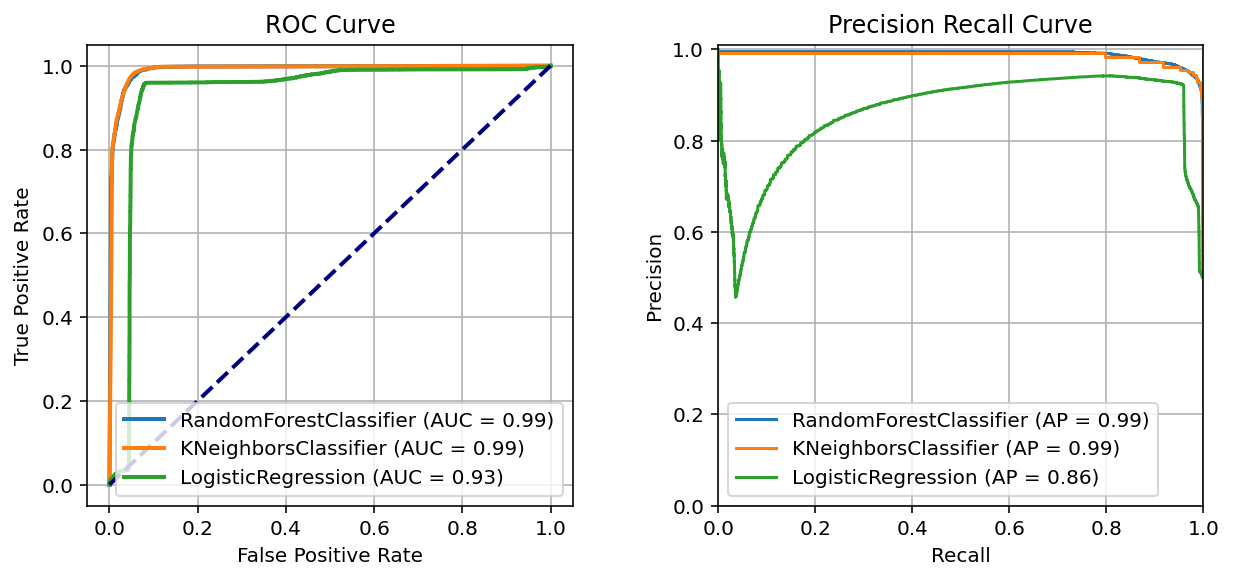

In [33]:
evaluate(trained_clfs, X_test, y_test)

## Feature importance

In [34]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

for clf in trained_clfs:
    print('\n', clf.__class__.__name__)
    perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
    display(show_weights(perm, feature_names=X_test.columns.to_list()))


 RandomForestClassifier



 KNeighborsClassifier



 LogisticRegression


## SHAP summary plots

Analysing how feature values affect the model prediction

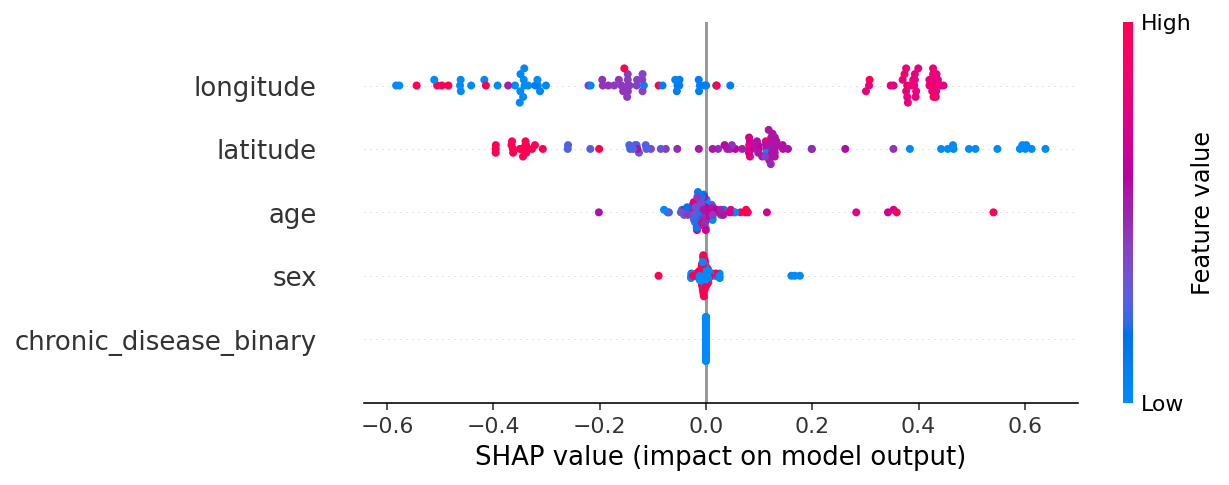

In [35]:
# Random Forest Classifier
X_train_summary = shap.kmeans(X_test, 100)
samples = X_test.sample(n=100)
explainer_rf = shap.KernelExplainer(trained_clfs[0].predict, X_train_summary)
shap_values_rf = explainer_rf.shap_values(samples)
shap.summary_plot(shap_values_rf, samples)

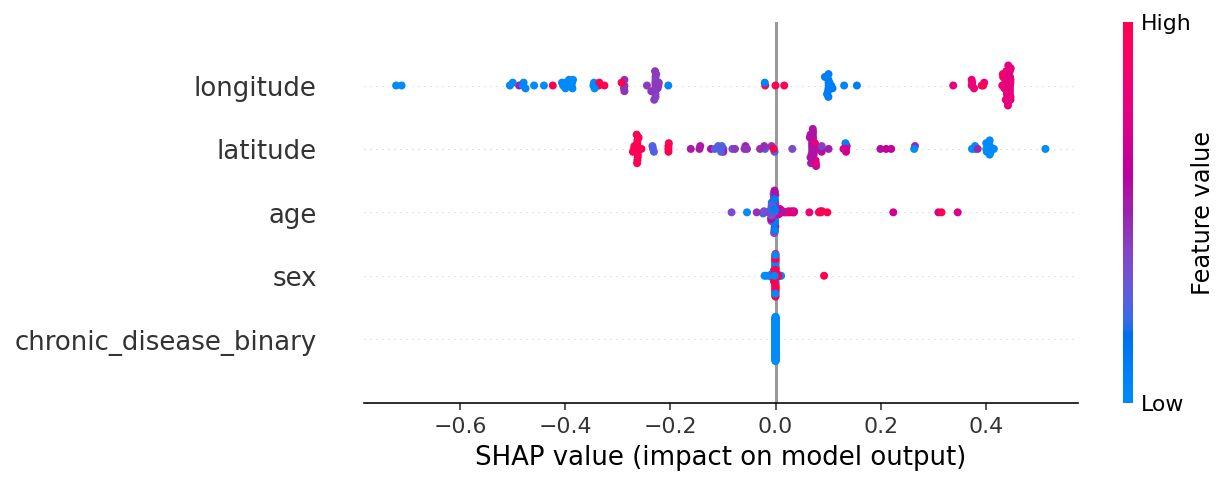

In [36]:
# K-Neighbors Classifier
explainer_knn = shap.KernelExplainer(trained_clfs[1].predict, X_train_summary)
shap_values_knn = explainer_knn.shap_values(samples)
shap.summary_plot(shap_values_knn, samples)

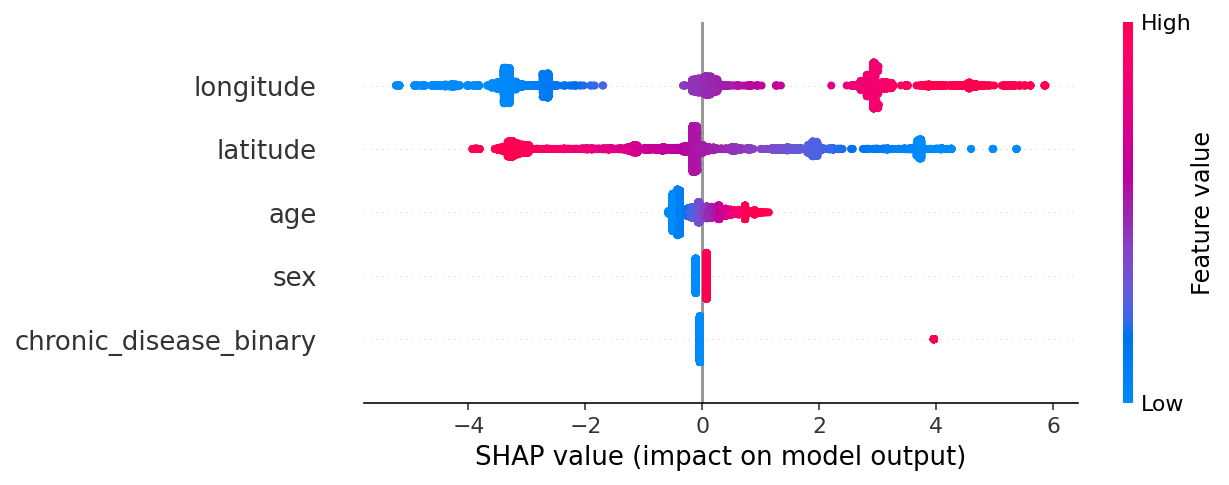

In [37]:
# Logistic Regression
explainer_lr = shap.LinearExplainer(trained_clfs[2], X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test)

## Lime instance explinations

We can look at a random entry to see how each feature affects the output of the model

In [38]:
feature_names = X_train.columns.to_list()
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="classification",
                                              class_names=['0', '1'],
                                              feature_names=feature_names)

i = random.randint(1, len(X_test))
print("Actual value: ", y_test.values[i])
for clf in trained_clfs:
    print(clf.__class__.__name__)
    explanation = explainer.explain_instance(X_test.values[i], clf.predict_proba,
                                             num_features=len(feature_names))
    explanation.show_in_notebook()

Actual value:  0.0
RandomForestClassifier


KNeighborsClassifier


LogisticRegression
